In [1]:
import os
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import torch

assert pyro.__version__.startswith('1.9.1')
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
news = fetch_20newsgroups(subset='all')
vectorizer = CountVectorizer(max_df=0.5, min_df=20, stop_words='english')
docs = torch.from_numpy(vectorizer.fit_transform(news['data']).toarray())

vocab = pd.DataFrame(columns=['word', 'index'])
vocab['word'] = vectorizer.get_feature_names_out()
vocab['index'] = vocab.index

In [4]:
# Cell line structure data frame, columns are cell lines, rows are gene mutations ordered by descending frequency
mutation_df = pd.read_csv("../dataset/Cancer/binary_mutations.csv")
# Response data frame, columns have cell line name, drug name and auc score
response_df = pd.read_csv("../dataset/Cancer/cell_drug_responses.csv").sample(n=10000, random_state=42)
# Drug structure data frame, columns are drug name, rows are morgan footprint entries
morgan_footprints_df = pd.read_csv("../dataset/Cancer/morgan_footprints.csv")
# Cell line reference information
depmap_mutation_ref = pd.read_csv("../dataset/Cancer/mutations_NAsdropped.csv")

/tmp/ipykernel_4913/2592700255.py:8: DtypeWarning: Columns (23,25,29,30,31,42,53,55) have mixed types. Specify dtype option on import or set low_memory=False.
  depmap_mutation_ref = pd.read_csv("../dataset/Cancer/mutations_NAsdropped.csv")


In [5]:
ccls = response_df["ccl_name"].unique().tolist()
from collections import Counter

gene_counts = Counter(
    mut
    for ccl in ccls
    for mut in depmap_mutation_ref[depmap_mutation_ref["cell_line_display_name"] == ccl]['gene'].tolist()
)


In [6]:
gene_unique_counts = Counter(
    mut
    for ccl in ccls
    for mut in depmap_mutation_ref[depmap_mutation_ref["cell_line_display_name"] == ccl]['gene'].unique()
)

In [7]:
max_gene = max(gene_counts, key=gene_counts.get)
max_count = gene_counts[max_gene]

print(max_gene, max_count)


TTN 8260


In [8]:
max_gene = max(gene_unique_counts, key=gene_unique_counts.get)
max_count = gene_unique_counts[max_gene]

print(max_gene, max_count)

TP53 824


In [9]:
filtered_dict = {key: value for key, value in gene_unique_counts.items() if value >= 30 and value <= 607}

In [10]:
len(filtered_dict)

5097

In [11]:
len(gene_unique_counts)

18306

In [12]:
len(ccls)

1181

In [13]:
len(gene_counts)

18306

In [14]:
vocab = pd.DataFrame(columns=['word', 'index'])
vocab['word'] = filtered_dict.keys()
vocab['index'] = vocab.index

In [92]:
vocab.to_pickle("vocab_10000.pkl")


In [15]:
response_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 242834 to 1151798
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ccl_name        10000 non-null  object 
 1   cpd_name        10000 non-null  object 
 2   normalized_auc  10000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 312.5+ KB


In [16]:
docs = []
ccls = response_df["ccl_name"].unique().tolist()
vocab_length = len(vocab)
for ccl in ccls:
    genes = Counter(
    gene
    for gene in depmap_mutation_ref[depmap_mutation_ref["cell_line_display_name"] == ccl]['gene']
)
    doc = np.zeros(vocab_length)
    for gene, count in genes.items():
        if (gene in vocab):
            doc[vocab[vocab["word"] == gene]["index"]] = count
    docs.append(doc)
docs_dict = dict(zip(ccls, docs))

In [20]:
data = []
labels = []
for _, row in response_df.iterrows():
    ccl = row["ccl_name"]
    cpd = row["cpd_name"]
    auc = row["normalized_auc"]
    data.append(np.concatenate((docs_dict[ccl], morgan_footprints_df[cpd].to_numpy())))
    labels.append(auc)


In [27]:
docs = torch.from_numpy(np.array(data))
labels_tensor = torch.from_numpy(np.array(labels))

In [ ]:
# import torch
# import numpy as np

# # Assuming response_df is already loaded

# # Convert the necessary columns to NumPy arrays for faster access
# ccls = response_df["ccl_name"].values
# cpds = response_df["cpd_name"].values
# aucs = response_df["normalized_auc"].values

# # Pre-allocate the lists (optional, you can directly append to the lists in some cases)
# batch_size = 100  # Choose a batch size based on available memory
# data_list = []
# labels_list = []

# # Loop over the DataFrame in chunks
# for i in range(0, len(response_df), batch_size):
#     batch_ccls = ccls[i:i + batch_size]
#     batch_cpds = cpds[i:i + batch_size]
#     batch_aucs = aucs[i:i + batch_size]

#     # Temporary storage for batch data
#     batch_data = []
#     batch_labels = []

#     # Process each entry in the batch
#     for ccl, cpd, auc in zip(batch_ccls, batch_cpds, batch_aucs):
#         # Efficiently concatenate the numpy arrays for ccl and cpd
#         data = np.concatenate((docs_dict[ccl], morgan_footprints_df[cpd].to_numpy()))
#         batch_data.append(data)
#         batch_labels.append(auc)

#     # Convert batch data to NumPy array and extend the lists
#     data_list.extend(batch_data)
#     labels_list.extend(batch_labels)

# # After the loop, convert to torch tensors
# data_tensor = torch.tensor(np.array(data_list), dtype=torch.float32)
# labels_tensor = torch.tensor(np.array(labels_list), dtype=torch.float32)


In [22]:
print('Dictionary size: %d' % len(vocab))
print('Corpus size: {}'.format(docs.shape))

Dictionary size: 5097
Corpus size: torch.Size([10000, 7145])


In [23]:
import math
import torch.nn as nn
import torch.nn.functional as F
from pyro.infer import SVI, TraceMeanField_ELBO
from tqdm import trange

In [84]:
class Encoder(nn.Module):
    # Base class for the encoder net, used in the guide
    def __init__(self, vocab_size, num_topics, hidden, dropout):
        super().__init__()
        self.drop = nn.Dropout(dropout)  # to avoid component collapse
        self.fc1 = nn.Linear(vocab_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fcmu = nn.Linear(hidden, num_topics)
        self.fclv = nn.Linear(hidden, num_topics)
        # NB: here we set `affine=False` to reduce the number of learning parameters
        # See https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
        # for the effect of this flag in BatchNorm1d
        self.bnmu = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse
        self.bnlv = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse

    def forward(self, inputs):
        h = F.softplus(self.fc1(inputs))
        h = F.softplus(self.fc2(h))
        h = self.drop(h)
        # μ and Σ are the outputs
        logtheta_loc = self.bnmu(self.fcmu(h))
        logtheta_logvar = self.bnlv(self.fclv(h))
        logtheta_scale = (0.5 * logtheta_logvar).exp()  # Enforces positivity
        return logtheta_loc, logtheta_scale


class Decoder(nn.Module):
    # Base class for the decoder net, used in the model
    def __init__(self, vocab_size, num_topics, dropout):
        super().__init__()
        self.beta = nn.Linear(num_topics, vocab_size, bias=False)
        self.bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, inputs):
        inputs = self.drop(inputs)
        # the output is σ(βθ)
        return F.softmax(self.bn(self.beta(inputs)), dim=1)
    

class ProdLDAWithMLP(nn.Module):
    def __init__(self, vocab_size, interv_dim, num_topics, hidden, dropout, mlp_hidden=[100, 50]):
        super().__init__()
        self.vocab_size = vocab_size
        self.num_topics = num_topics
        self.interv_dim = interv_dim
        self.encoder = Encoder(vocab_size, num_topics, hidden, dropout)
        self.decoder = Decoder(vocab_size, num_topics, dropout)

        # Three-layer MLP for regression
        self.mlp = nn.Sequential(
            nn.Linear(num_topics + interv_dim, mlp_hidden[0]),
            nn.ReLU(),
            nn.Linear(mlp_hidden[0], mlp_hidden[1]),
            nn.ReLU(),
            nn.Linear(mlp_hidden[1], 1)  # Single output for regression
        )

    def model(self, docs, y=None):
        pyro.module("decoder", self.decoder)
        pyro.module("mlp", self.mlp)  # Register MLP in Pyro
        
        with pyro.plate("documents", docs.shape[0]):
            # Prior for topic distribution (logistic-normal)
            device = docs.device
            # print(f"doc device {device}")
            logtheta_loc = docs.new_zeros((docs.shape[0], self.num_topics), device=device)
            logtheta_scale = docs.new_ones((docs.shape[0], self.num_topics), device=device)
            logtheta = pyro.sample("logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))
            theta = F.softmax(logtheta, -1)  # Convert to probability simplex

            # Generate word counts (original ProdLDA)
            count_param = self.decoder(theta)
            total_count = int(docs.sum(-1).max())
            pyro.sample('obs', dist.Multinomial(total_count, count_param), obs=docs[:, 0:self.vocab_size])

            # Regression component: Predict y using MLP
            theta_r = torch.cat([theta, docs[:, self.vocab_size:]], dim=-1)
            # print(f"theta shape: {theta.shape}")
            # print(f"doc shape: {docs.shape}")
            # print(f"vocab size: {self.vocab_size}")
            # print(f"interv shape: {docs[:, self.vocab_size:].shape}")
            # print(f"theta_r shape: {theta_r.shape}")
            # print(f"Expected shape: ({docs.shape[0]}, {self.num_topics + self.interv_dim})")
            assert theta_r.shape == (docs.shape[0], self.num_topics + self.interv_dim)
            y_pred = self.mlp(theta_r).squeeze(-1)  # Forward pass through MLP
            sigma = pyro.sample("sigma", dist.HalfCauchy(1.0)).to(device)  # Uncertainty in y

            # Likelihood of y given predicted y_pred
            if y is not None:
                pyro.sample("y_obs", dist.Normal(y_pred, sigma), obs=y)

    def guide(self, docs, y=None):
        pyro.module("encoder", self.encoder)

        with pyro.plate("documents", docs.shape[0]):
            # Approximate posterior for topic proportions
            logtheta_loc, logtheta_scale = self.encoder(docs[:,0:self.vocab_size])
            pyro.sample("logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))

            # Estimate sigma for regression
            pyro.sample("sigma", dist.HalfCauchy(1.0))

    def beta(self):
        return self.decoder.beta.weight.cpu().detach().T


def plot_word_cloud(b, ax, v, n):
    sorted_, indices = torch.sort(b, descending=True)
    df = pd.DataFrame(indices[:100].numpy(), columns=['index'])
    words = pd.merge(df, vocab[['index', 'word']],
                     how='left', on='index')['word'].values.tolist()
    sizes = (sorted_[:100] * 1000).int().numpy().tolist()
    freqs = {words[i]: sizes[i] for i in range(len(words))}
    wc = WordCloud(background_color="white", width=800, height=500)
    wc = wc.generate_from_frequencies(freqs)
    ax.set_title('Topic %d' % (n + 1))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")


In [85]:
# setting global variables
seed = 0
torch.manual_seed(seed)
pyro.set_rng_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_topics = 20 if not smoke_test else 3
docs = docs.float().to(device)
labels_tensor = labels_tensor.float().to(device)
batch_size = 32
learning_rate = 1e-3
num_epochs = 50 if not smoke_test else 1

In [94]:
import matplotlib.pyplot as plt

# Clear Pyro parameter store
pyro.clear_param_store()

# Initialize model
prodLDA = ProdLDAWithMLP(
    vocab_size=docs.shape[1]-2048,
    interv_dim=2048,
    num_topics=num_topics,
    hidden=100 if not smoke_test else 10,
    dropout=0.2,
    mlp_hidden=[100, 50]
)
prodLDA.to(device)

# Define optimizer and loss function
optimizer = pyro.optim.Adam({"lr": learning_rate})
svi = SVI(prodLDA.model, prodLDA.guide, optimizer, loss=TraceMeanField_ELBO())

# Number of batches
num_batches = int(math.ceil(docs.shape[0] / batch_size)) if not smoke_test else 1

# Initialize loss tracking
elbo_losses = []
reg_losses = []
total_losses = []

# Training loop
bar = trange(num_epochs, desc="Training")
for epoch in bar:
    running_elbo_loss = 0.0
    running_reg_loss = 0.0
    running_total_loss = 0.0

    for i in range(num_batches):
        batch_docs = docs[i * batch_size:(i + 1) * batch_size, :].to(device)
        batch_labels = labels_tensor[i * batch_size:(i + 1) * batch_size].to(device)

        # Step 1: Compute ELBO Loss
        elbo_loss = svi.step(batch_docs, batch_labels)/prodLDA.vocab_size

        # Step 2: Compute Regression Loss separately
        prodLDA.eval()  # Switch to evaluation mode for prediction
        with torch.no_grad():
            theta = prodLDA.encoder(batch_docs[:, :docs.shape[1]-2048])[0]  # Get topic distribution
            theta_r = torch.cat([theta, batch_docs[:, docs.shape[1]-2048:]], dim=-1)
            y_pred = prodLDA.mlp(theta_r).squeeze(-1)  # Predict target values

        prodLDA.train()  # Switch back to training mode

        reg_loss = torch.nn.functional.mse_loss(y_pred, batch_labels)  # MSE Loss for regression

        # Combine losses
        total_loss = elbo_loss + reg_loss.item()
        running_elbo_loss += elbo_loss / batch_docs.size(0)
        running_reg_loss += reg_loss.item() / batch_docs.size(0)
        running_total_loss += total_loss / batch_docs.size(0)

    # Store loss values for plotting
    elbo_losses.append(running_elbo_loss)
    reg_losses.append(running_reg_loss)
    total_losses.append(running_total_loss)
    print(f"epoch {epoch}")
    print(f"elbo loss {elbo_losses}")
    print(f"reg loss {reg_losses}")
    print(f"total loss {total_losses}")

    bar.set_postfix(epoch_loss='{:.2e}'.format(running_total_loss))

# Plot training loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), elbo_losses, label="ELBO Loss")
plt.plot(range(num_epochs), reg_losses, label="Regression Loss")
plt.plot(range(num_epochs), total_losses, label="Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid()
plt.show()


Training:   2%|▎            | 1/50 [00:04<03:31,  4.31s/it, epoch_loss=1.25e+03]

epoch 0
elbo loss [1247.89795260217]
reg loss [1.1783783150603995]
total loss [1249.0763309172305]


Training:   4%|▌            | 2/50 [00:07<02:54,  3.65s/it, epoch_loss=1.22e+01]

epoch 1
elbo loss [1247.89795260217, 11.156847849391772]
reg loss [1.1783783150603995, 1.0257160873152316]
total loss [1249.0763309172305, 12.182563936707004]


Training:   6%|▊            | 3/50 [00:10<02:42,  3.45s/it, epoch_loss=8.72e+02]

epoch 2
elbo loss [1247.89795260217, 11.156847849391772, 868.7439311356646]
reg loss [1.1783783150603995, 1.0257160873152316, 2.8488203961169347]
total loss [1249.0763309172305, 12.182563936707004, 871.5927515317816]


Training:   8%|█            | 4/50 [00:14<02:41,  3.50s/it, epoch_loss=2.73e+01]

epoch 3
elbo loss [1247.89795260217, 11.156847849391772, 868.7439311356646, 25.870218156481908]
reg loss [1.1783783150603995, 1.0257160873152316, 2.8488203961169347, 1.461949757183902]
total loss [1249.0763309172305, 12.182563936707004, 871.5927515317816, 27.33216791366581]


Training:  10%|█▎           | 5/50 [00:18<02:42,  3.61s/it, epoch_loss=1.34e+01]

epoch 4
elbo loss [1247.89795260217, 11.156847849391772, 868.7439311356646, 25.870218156481908, 11.940561597104491]
reg loss [1.1783783150603995, 1.0257160873152316, 2.8488203961169347, 1.461949757183902, 1.4990475995000452]
total loss [1249.0763309172305, 12.182563936707004, 871.5927515317816, 27.33216791366581, 13.439609196604536]


Training:  12%|█▌           | 6/50 [00:21<02:34,  3.50s/it, epoch_loss=1.05e+02]

epoch 5
elbo loss [1247.89795260217, 11.156847849391772, 868.7439311356646, 25.870218156481908, 11.940561597104491, 102.86758313600946]
reg loss [1.1783783150603995, 1.0257160873152316, 2.8488203961169347, 1.461949757183902, 1.4990475995000452, 1.7411952065303922]
total loss [1249.0763309172305, 12.182563936707004, 871.5927515317816, 27.33216791366581, 13.439609196604536, 104.60877834253985]


Training:  14%|█▊           | 7/50 [00:25<02:40,  3.74s/it, epoch_loss=3.86e+04]

epoch 6
elbo loss [1247.89795260217, 11.156847849391772, 868.7439311356646, 25.870218156481908, 11.940561597104491, 102.86758313600946, 38551.23340817091]
reg loss [1.1783783150603995, 1.0257160873152316, 2.8488203961169347, 1.461949757183902, 1.4990475995000452, 1.7411952065303922, 1.561064834939316]
total loss [1249.0763309172305, 12.182563936707004, 871.5927515317816, 27.33216791366581, 13.439609196604536, 104.60877834253985, 38552.79447300585]


Training:  16%|██           | 8/50 [00:29<02:35,  3.70s/it, epoch_loss=1.13e+01]

epoch 7
elbo loss [1247.89795260217, 11.156847849391772, 868.7439311356646, 25.870218156481908, 11.940561597104491, 102.86758313600946, 38551.23340817091, 8.942620051943223]
reg loss [1.1783783150603995, 1.0257160873152316, 2.8488203961169347, 1.461949757183902, 1.4990475995000452, 1.7411952065303922, 1.561064834939316, 2.324331625713967]
total loss [1249.0763309172305, 12.182563936707004, 871.5927515317816, 27.33216791366581, 13.439609196604536, 104.60877834253985, 38552.79447300585, 11.266951677657197]


Training:  18%|██▎          | 9/50 [00:32<02:26,  3.57s/it, epoch_loss=1.11e+01]

epoch 8
elbo loss [1247.89795260217, 11.156847849391772, 868.7439311356646, 25.870218156481908, 11.940561597104491, 102.86758313600946, 38551.23340817091, 8.942620051943223, 8.964438139234588]
reg loss [1.1783783150603995, 1.0257160873152316, 2.8488203961169347, 1.461949757183902, 1.4990475995000452, 1.7411952065303922, 1.561064834939316, 2.324331625713967, 2.1081034479429945]
total loss [1249.0763309172305, 12.182563936707004, 871.5927515317816, 27.33216791366581, 13.439609196604536, 104.60877834253985, 38552.79447300585, 11.266951677657197, 11.072541587177584]


Training:  20%|██▍         | 10/50 [00:35<02:18,  3.47s/it, epoch_loss=2.97e+01]

epoch 9
elbo loss [1247.89795260217, 11.156847849391772, 868.7439311356646, 25.870218156481908, 11.940561597104491, 102.86758313600946, 38551.23340817091, 8.942620051943223, 8.964438139234588, 27.851472425395325]
reg loss [1.1783783150603995, 1.0257160873152316, 2.8488203961169347, 1.461949757183902, 1.4990475995000452, 1.7411952065303922, 1.561064834939316, 2.324331625713967, 2.1081034479429945, 1.8738736604573205]
total loss [1249.0763309172305, 12.182563936707004, 871.5927515317816, 27.33216791366581, 13.439609196604536, 104.60877834253985, 38552.79447300585, 11.266951677657197, 11.072541587177584, 29.725346085852646]


Training:  22%|██▋         | 11/50 [00:39<02:21,  3.62s/it, epoch_loss=1.66e+01]

epoch 10
elbo loss [1247.89795260217, 11.156847849391772, 868.7439311356646, 25.870218156481908, 11.940561597104491, 102.86758313600946, 38551.23340817091, 8.942620051943223, 8.964438139234588, 27.851472425395325, 14.816269958395797]
reg loss [1.1783783150603995, 1.0257160873152316, 2.8488203961169347, 1.461949757183902, 1.4990475995000452, 1.7411952065303922, 1.561064834939316, 2.324331625713967, 2.1081034479429945, 1.8738736604573205, 1.8184827881632373]
total loss [1249.0763309172305, 12.182563936707004, 871.5927515317816, 27.33216791366581, 13.439609196604536, 104.60877834253985, 38552.79447300585, 11.266951677657197, 11.072541587177584, 29.725346085852646, 16.634752746559037]


Training:  24%|██▉         | 12/50 [00:43<02:15,  3.57s/it, epoch_loss=1.31e+01]

epoch 11
elbo loss [1247.89795260217, 11.156847849391772, 868.7439311356646, 25.870218156481908, 11.940561597104491, 102.86758313600946, 38551.23340817091, 8.942620051943223, 8.964438139234588, 27.851472425395325, 14.816269958395797, 11.621929124357287]
reg loss [1.1783783150603995, 1.0257160873152316, 2.8488203961169347, 1.461949757183902, 1.4990475995000452, 1.7411952065303922, 1.561064834939316, 2.324331625713967, 2.1081034479429945, 1.8738736604573205, 1.8184827881632373, 1.5185440401546657]
total loss [1249.0763309172305, 12.182563936707004, 871.5927515317816, 27.33216791366581, 13.439609196604536, 104.60877834253985, 38552.79447300585, 11.266951677657197, 11.072541587177584, 29.725346085852646, 16.634752746559037, 13.140473164511949]


Training:  26%|███         | 13/50 [00:46<02:13,  3.60s/it, epoch_loss=1.55e+02]

epoch 12
elbo loss [1247.89795260217, 11.156847849391772, 868.7439311356646, 25.870218156481908, 11.940561597104491, 102.86758313600946, 38551.23340817091, 8.942620051943223, 8.964438139234588, 27.851472425395325, 14.816269958395797, 11.621929124357287, 152.6433689685482]
reg loss [1.1783783150603995, 1.0257160873152316, 2.8488203961169347, 1.461949757183902, 1.4990475995000452, 1.7411952065303922, 1.561064834939316, 2.324331625713967, 2.1081034479429945, 1.8738736604573205, 1.8184827881632373, 1.5185440401546657, 2.4104236589046195]
total loss [1249.0763309172305, 12.182563936707004, 871.5927515317816, 27.33216791366581, 13.439609196604536, 104.60877834253985, 38552.79447300585, 11.266951677657197, 11.072541587177584, 29.725346085852646, 16.634752746559037, 13.140473164511949, 155.05379262745282]


Training:  28%|███▎        | 14/50 [00:50<02:15,  3.76s/it, epoch_loss=4.33e+00]

epoch 13
elbo loss [1247.89795260217, 11.156847849391772, 868.7439311356646, 25.870218156481908, 11.940561597104491, 102.86758313600946, 38551.23340817091, 8.942620051943223, 8.964438139234588, 27.851472425395325, 14.816269958395797, 11.621929124357287, 152.6433689685482, 2.9809721396066213]
reg loss [1.1783783150603995, 1.0257160873152316, 2.8488203961169347, 1.461949757183902, 1.4990475995000452, 1.7411952065303922, 1.561064834939316, 2.324331625713967, 2.1081034479429945, 1.8738736604573205, 1.8184827881632373, 1.5185440401546657, 2.4104236589046195, 1.3530849432572722]
total loss [1249.0763309172305, 12.182563936707004, 871.5927515317816, 27.33216791366581, 13.439609196604536, 104.60877834253985, 38552.79447300585, 11.266951677657197, 11.072541587177584, 29.725346085852646, 16.634752746559037, 13.140473164511949, 155.05379262745282, 4.334057082863893]


Training:  28%|███▎        | 14/50 [00:53<02:18,  3.84s/it, epoch_loss=4.33e+00]


KeyboardInterrupt: 

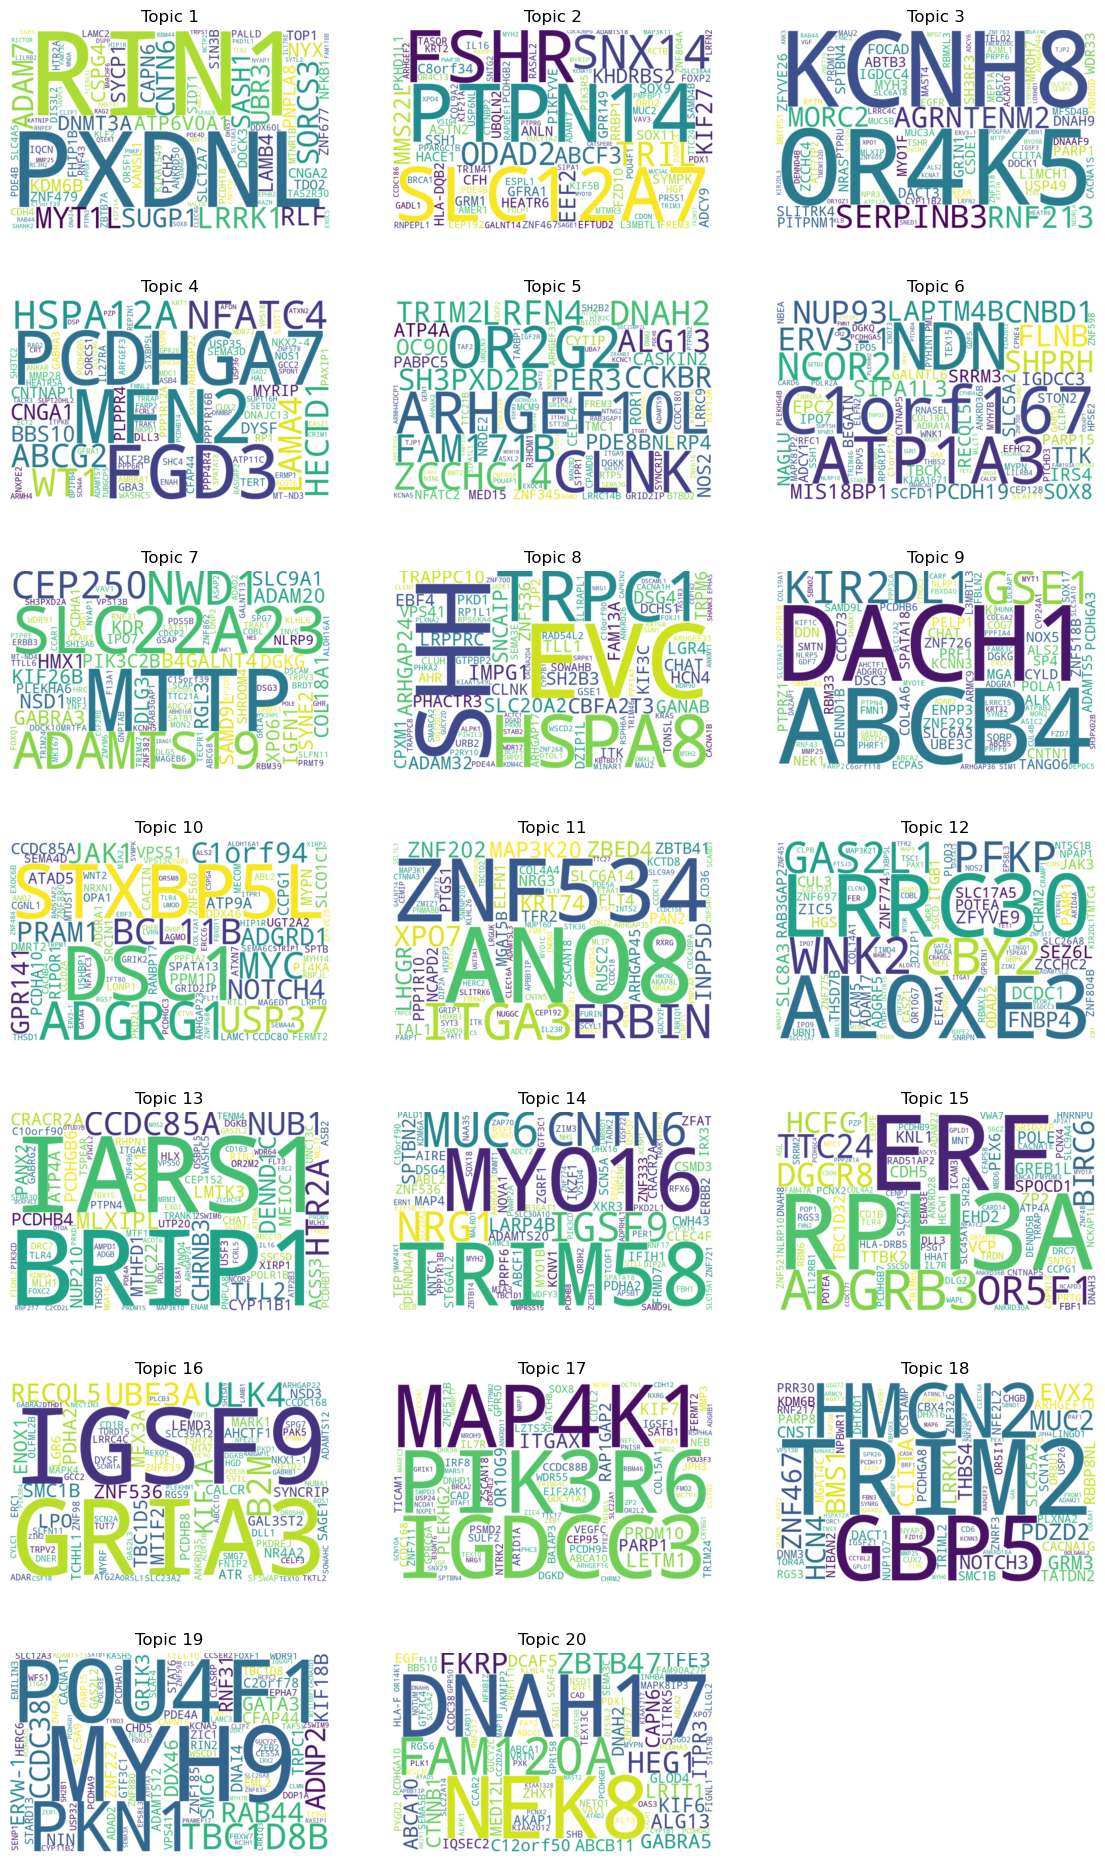

In [87]:
def plot_word_cloud(b, ax, v, n):
    sorted_, indices = torch.sort(b, descending=True)
    df = pd.DataFrame(indices[:100].numpy(), columns=['index'])
    words = pd.merge(df, vocab[['index', 'word']],
                     how='left', on='index')['word'].values.tolist()
    sizes = (sorted_[:100] * 1000).int().numpy().tolist()
    freqs = {words[i]: sizes[i] for i in range(len(words))}
    wc = WordCloud(background_color="white", width=800, height=500)
    wc = wc.generate_from_frequencies(freqs)
    ax.set_title('Topic %d' % (n + 1))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")

if not smoke_test:
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud

    beta = prodLDA.beta()
    fig, axs = plt.subplots(7, 3, figsize=(14, 24))
    for n in range(beta.shape[0]):
        i, j = divmod(n, 3)
        plot_word_cloud(beta[n], axs[i, j], vocab, n)
    axs[-1, -1].axis('off');

    plt.show()

In [90]:
import torch

# Save tensors
torch.save(docs, "response_10000.pt")
torch.save(labels_tensor, "labels_10000.pt")

# Load tensors
docs_loaded = torch.load("response_10000.pt")
labels_loaded = torch.load("labels_10000.pt")

print(docs_loaded.shape, labels_loaded.shape)  # Check shapes to verify


torch.Size([10000, 7145]) torch.Size([10000])
